# Question 1.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
from time import time
import warnings
warnings.filterwarnings('ignore') 

np.random.seed(0)
np.set_printoptions(threshold=500)

In [3]:
mat = loadmat('data_train.mat')
mat2 = loadmat('data_test.mat')
X = np.array(mat["X"])   # train data predictors
y = mat["y"]   # train data labels
Xt = mat2["Xt"] # test data predictors
yt = mat2["yt"] # test data labels
y = np.reshape(y,(y.shape[0],))
yt = np.reshape(yt,(yt.shape[0],))

## a)

In [163]:
# Written from scratch

def vote_fn(preds) -> np.ndarray:
    preds = np.array(list(preds))
    vote = np.sum(preds, axis=0) # Voting happens by summing the -1 & 1 values on each column
    zero_ind = np.where(vote == 0)[0] # Finds ties where -1's and 1's cancel out
    vote = np.where(vote<0,-1,1)
    coin_flips = np.random.choice([-1, 1], len(zero_ind))
    vote[zero_ind] = coin_flips # Replace even scores with a random guess
    return vote
    
def MyBagging(X, y, B):
    N = len(X)
    trees = []
    err = [] 
    sample_indicies = np.stack(np.random.choice(range(N), size=N, replace=True) for _ in range(B))
    print(sample_indicies.shape)
    si_sets = [set(si) for si in sample_indicies]
    cache = np.zeros_like([range(B)]*N)
    oob = set()
    full_set = set(range(N))
    for i in range(B):
        sample_i = np.random.choice(range(N), size=N, replace=True)
        x_sample, y_sample = X[sample_indicies[i]], y[sample_indicies[i]] # Get bootstrap samples
        tree = DecisionTreeClassifier()
        tree.fit(x_sample, y_sample)
        trees.append(tree)
        assert (full_set - si_sets[i]) & si_sets[i] == set()

        ite_err = []
        pred_vec = np.zeros(N)
        for i_tree in range(i):
            idx = sample_indicies[i_tree]
            used = set(idx)
            unused = set(range(N)) - used
            unused_idx = list(unused)
            oob_samples = X[unused_idx]
            oob_ans = y[unused_idx]
            preds = trees[i_tree].predict(oob_samples)
            pred_vec[unused_idx] += preds
        vote = np.where(pred_vec==0, np.random.choice([-1, 1]), pred_vec)
        vote = np.sign(vote)
        error = np.mean(vote != y)
        err.append(error)

    return trees, err
               

(200, 2000)


Time: 14.4701 s


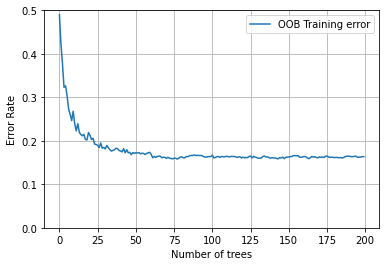

In [164]:
t = time()
trees, err = MyBagging(X, y, 200)
print(f'Time: {time()-t:.4f} s')

plt.plot(err, label='OOB Training error')
plt.ylabel('Error Rate')
plt.xlabel('Number of trees')
plt.legend()
plt.grid()
plt.ylim(0, 0.5)
plt.show()

## b)

In [156]:
def PredictBagging(trees, X, y):
    test_err = []
    for i in range(len(trees)):
        ite_err = []
        preds = []
        for j in range(i+1):
            pred = trees[j].predict(X)
            preds.append(pred)

        vote = vote_fn(preds)
        ans = y.flatten()
        matches = vote == ans # Checks where the voted result is correct
        error = np.sum(matches == 0)/len(matches)
        test_err.append(error)

    return test_err

Time: 16.7791 s


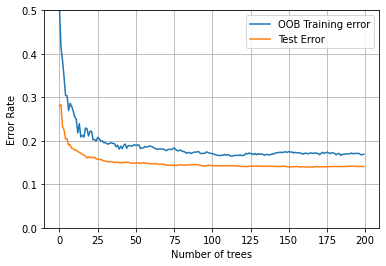

In [158]:
t = time()
test_err = PredictBagging(trees, Xt, yt)
print(f'Time: {time()-t:.4f} s')

plt.plot(err, label='OOB Training error')
plt.plot(test_err, label='Test Error')
plt.ylabel('Error Rate')
plt.xlabel('Number of trees')
plt.legend()
plt.ylim(0, 0.5)
plt.grid()
plt.show()
        

## c)

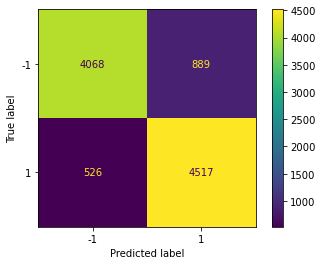

In [149]:
predictions = vote_fn(map(lambda tree: tree.predict(Xt), trees))
cm = confusion_matrix(yt, predictions, labels=trees[0].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=trees[0].classes_)
disp.plot() 

# Question 2.
## a)

In [200]:
def my_random_forest(X, y, B):
    N = len(X)
    trees = []
    err = [] 
    oob_ind = set()
    sample_indicies = np.stack(np.random.choice(range(N), size=N, replace=True) for _ in range(B))
    sample_sets = [set(si) for si in sample_indicies]
    full_set = set(range(B))
    for i in range(B):
        X_i, y_i = X[sample_indicies[i]], y[sample_indicies[i]]
        tree = DecisionTreeClassifier(min_samples_leaf=3, max_features=2)
        tree.fit(X, y)
        trees.append(tree)
        oob_ind = oob_ind | (full_set - sample_sets[i])

        preds = np.zeros((len(trees), N))
        for t_i, tree in enumerate(trees):
            per_tree_ind = list(oob_ind - sample_sets[t_i])
            pred = tree.predict(X[per_tree_ind])
            preds[t_i, per_tree_ind] = pred

        vote = np.sum(preds, axis=0) # Sum the predictions to get the majority vote
        vote = np.where(vote == 0, np.random.choice([-1, 1]), vote) # Break ties
        vote = np.sign(vote) # Apply SIGN func
  
        error = np.sum(vote[list(oob_ind)] != y[list(oob_ind)]) / len(oob_ind) # Calculate errors
        err.append(error)

    return trees, err

preds: (1, 2000)
Vote: 79
y ind: 79
error: 0.06329113924050633
preds: (2, 2000)
Vote: 119
y ind: 119
error: 0.07563025210084033
preds: (3, 2000)
Vote: 150
y ind: 150
error: 0.06666666666666667
preds: (4, 2000)
Vote: 168
y ind: 168
error: 0.05952380952380952
preds: (5, 2000)
Vote: 182
y ind: 182
error: 0.04945054945054945
Time: 2.2118 s
Time: 16.4057 s


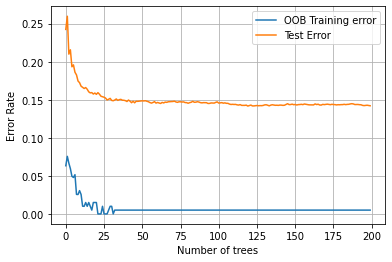

In [201]:
t = time()
ran_trees, err = my_random_forest(X, y, 200)
print(f'Time: {time()-t:.4f} s')
t = time()
test_err = PredictBagging(ran_trees, Xt, yt)
print(f'Time: {time()-t:.4f} s')

plt.plot(err, label='OOB Training error')
plt.plot(test_err, label='Test Error')
plt.ylabel('Error Rate')
plt.xlabel('Number of trees')
plt.legend()
plt.ylim(0, 0.5)
plt.grid()
plt.show()
        

# Question 3.
## a)

In [159]:
def my_adaboost_m1(X, y, M):
    N = len(X)
    G = []
    alphas = []
    w = np.ones(N)/N
    for m in range(M):
        stump = DecisionTreeClassifier(max_depth=1)
        stump.fit(X, y, sample_weight=w)
        G.append(stump)
        pred = stump.predict(X)
        one_if = np.where(y != pred, 1, 0) # Apply "1 if" operation 
        error = np.sum(w * one_if) / np.sum(w) # Calculate error
        alpha = np.log((1-error) / error) #      and alpha
        alphas.append(alpha)
        w *= np.exp(alpha * one_if)
    return G, alphas

t = time()
G, alphas = my_adaboost_m1(X, y, 600)
print(f'Time: {time()-t:.3f} s')

Time: 1.685 s


## b)

In [160]:
def predict_adaboost_m1(X, y, G, alphas):
    preds = np.zeros((len(G), len(y)))
    y_hats = []
    err = []
    for i, stump in enumerate(G):
        pred_i = stump.predict(X)
        alpha = np.array(alphas[i])
        preds[i] = (alpha * pred_i)
        pred = np.array(preds)
        if 0:
            print(f'i:{i}')
            print(f'alpha:\n{alpha}')
            print(f'pred:\n{pred}\n-1: {np.sum(pred == -1)}\n1: {np.sum(pred == 1)}')
            print(f'ans:\n{y}')
            break
        vote = np.sum(preds, axis=0)
        vote = np.where(vote == 0, np.random.choice([-1, 1]), vote)
        y_hat = np.sign(vote)
        y_hats.append(y_hat)
        #error = np.mean(np.where(y_hat != y, 0, 1))
        error = 1 - np.mean(y_hat == y)
        err.append(error)
    return y_hats, err

t = time()
y_hats, ada_err = predict_adaboost_m1(X, y, G, alphas)
print(f'Time: {time()-t:.3f} s - train')
t = time()
y_hats_test, ada_test_err = predict_adaboost_m1(Xt, yt, G, alphas)
print(f'Time: {time()-t:.3f} s - test')

Time: 0.472 s - train
Time: 4.011 s - test


## c)

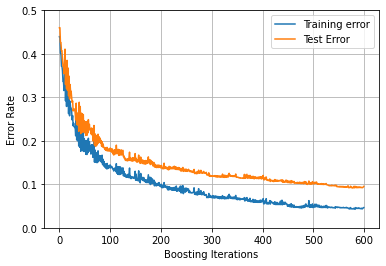

In [161]:
plt.plot(ada_err, label='Training error')
plt.plot(ada_test_err, label='Test Error')
plt.ylabel('Error Rate')
plt.xlabel('Boosting Iterations')
plt.legend()
plt.ylim(0, 0.5)
plt.grid()
plt.show()

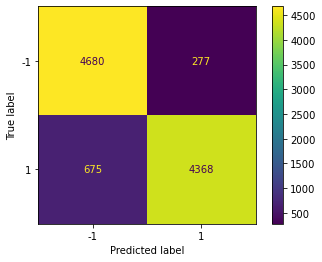

In [162]:
predictions = list(map(lambda tree: tree.predict(Xt), G))
vote = np.sum(predictions, axis=0)
vote = np.where(vote == 0, np.random.choice([-1, 1]), vote)
y_hat = np.sign(vote)
cm = confusion_matrix(yt, y_hats_test[-1], labels=G[0].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=G[0].classes_)
disp.plot() 